# Аугментация

Операция свертки инвариантна к сдвигу (не важно, где на изображении находится объект), но не к масштабированию и повороту.


<img src="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/affine1.png" width="700">

У этой проблемы нет красивого решения: если в обучающей выборке не было котов, висящих вверх лапами, то модель не будет их различать.

Нужно дополнить датасет такими изображениями, и самый простой способ это сделать — это преобразовать (отразить, повернуть, масштабировать и т.д.) уже имеющиеся.

**Аугмента́ция** (от лат. augmentatio — увеличение, расширение) — увеличение выборки обучающих данных через модификацию существующих данных.

Модели глубокого обучения обычно требуют большого количества данных для обучения. В целом, чем больше данных, тем лучше для обучения модели. В то же время получение огромных объемов данных сопряжено со своими проблемами (например, с нехваткой размеченных данных или с трудозатратами, сопряженными с разметкой).

Вместо того, чтобы тратить дни на сбор данных вручную, мы можем использовать методы аугментации для автоматической генерации новых примеров из уже имеющихся.

Помимо увеличения размеченных датасетов, многие методы *self-supervised learning* построены на использовании разных аугментаций одного и того же сэмпла.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/augmentations_examples.png" width="700"></center>
<center><em>Примеры аугментаций картинки. </em></center>

**Важный момент**: при обучении модели мы используем разбиение данных на `train-val-test`. Аугментации стоит применять только на `train`. Почему так? Конечная цель обучения нейросети — это применение на реальных данных, которые сеть не видела. Поэтому для адекватной оценки качества модели валидационные и тестовые данные изменять не нужно.

В любом случае, `test` должен быть отделен от данных еще до того, как они попали в `DataLoader` или нейросеть.

Другое дело, что аугментации на тесте можно использовать как метод ансамблирования в случае классификации. Можно взять sample → создать несколько его копий → по-разному их аугментировать → предсказать класс на каждой из этих аугментированных копий → выбрать наиболее вероятный класс голосованием (такой функционал реализован, например, в YOLO).

Инструментарий для аугментаций [встроен в PyTorch 🛠️[doc]](https://pytorch.org/vision/stable/transforms.html). Мы уже пользовались им, когда создавали датасет и передавали в конструктор параметр **transform**.

In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Resize, Normalize, Compose

transform = Compose(
    [Resize(224), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 55155313.60it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


Собственно, экземпляр объекта `torchvision.transforms.Resize`, созданный первым в списке (`Resize(224)`), и аугментирует изображение.

*Отметим что аугментация происходит "на лету": аугментированное изображение не сохраняется на диск и сразу передается в модель.*

Пакет `torchvision.transforms` [🛠️[doc]](https://pytorch.org/vision/0.9/transforms.html) позволяет выполнить  довольно много различных аугментаций. Посмотрим на некоторые из них.



Загрузим и отобразим пример картинки. Картинку отмасштабируем, чтобы она не занимала весь экран.

In [2]:
import torch


# setting random seed for reproducible illustrations
torch.manual_seed(42)

URL = (
    "https://ml.gan4x4.ru/msu/dev-2.1/L06/capybara_image.jpg"
)
!wget -q $URL -O test.jpg

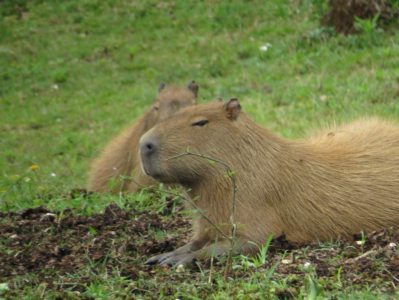

In [3]:
from PIL import Image
from torchvision import transforms
from IPython.display import display

input_img = Image.open("/content/test.jpg")
input_img = transforms.Resize(size=300)(input_img)
display(input_img)

Рассмотрим несколько примеров аугментаций картинок. С полным списком можно ознакомиться на сайте [документации torchvision 🛠️[doc]](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).

## Random Rotation

Трансформация `transforms.Random Rotation` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html?highlight=randomrotation#torchvision.transforms.RandomRotation) принимает параметр `degrees` — диапазон углов, из которого выбирается случайный угол для поворота изображения.

Создадим переменную `transform`, в которую добавим нашу аугментацию, и применим ее к исходному изображению:

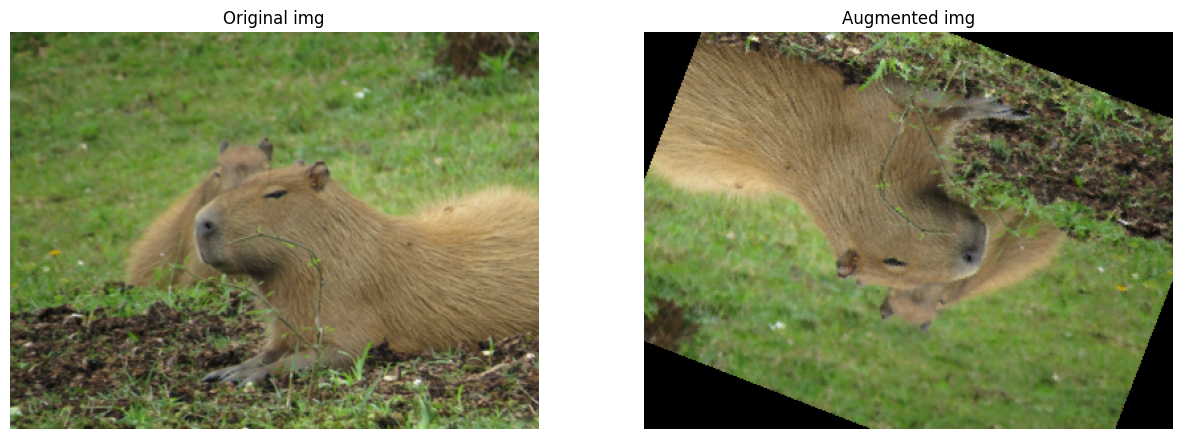

In [4]:
import matplotlib.pyplot as plt


def plot_augmented_img(transform, input_img):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    augmented_img = transform(input_img)
    ax[0].imshow(input_img)
    ax[0].set_title("Original img")
    ax[0].axis("off")

    ax[1].imshow(augmented_img)
    ax[1].set_title("Augmented img")
    ax[1].axis("off")
    plt.show()


transform = transforms.RandomRotation(degrees=(0, 180))

plot_augmented_img(transform, input_img)

## Gaussian Blur

`transforms.GaussianBlur` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html?highlight=gaussianblur#torchvision.transforms.GaussianBlur) размывает изображение с помощью фильтра Гаусса.

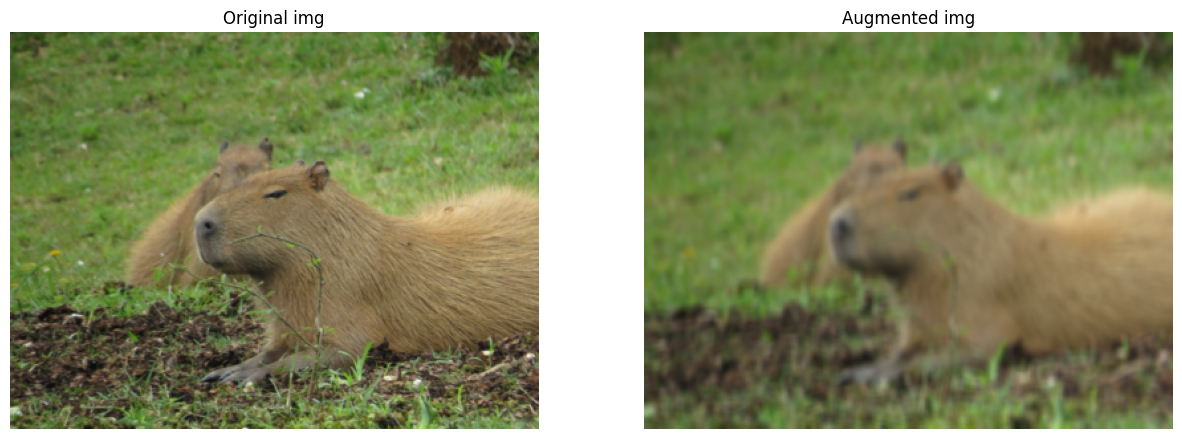

In [5]:
transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))

plot_augmented_img(transform, input_img)

## Random Erasing

`transforms.RandomErasing` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomErasing.html?highlight=transforms+randomerasing#torchvision.transforms.RandomErasing) стирает на изображении произвольный прямоугольник. Она имеет параметр `p` — вероятность, с которой данная трансформация вообще применится к изображению.

Данная трансформация работает только с `torch.Tensor`, поэтому предварительно нужно применить трансформацию `ToTensor`, а затем `ToPILImage`, чтобы воспользоваться нашей функцией для отображения.



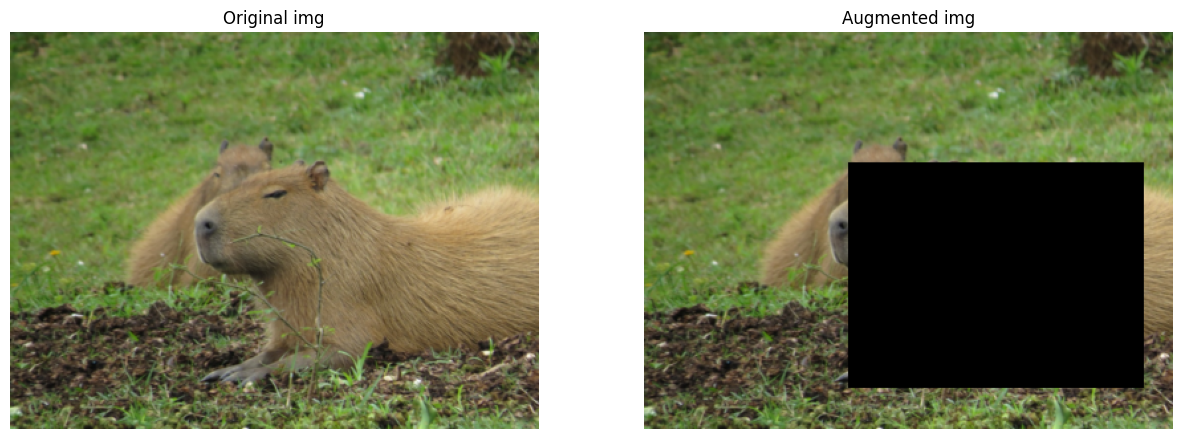

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomErasing(p=1), transforms.ToPILImage()]
)

plot_augmented_img(transform, input_img)

Не лишним будет заметить, что некоторые трансформации могут существенно исказить изображение. Например, здесь `RandomErasing` практически полностью стерла основной объект на снимке — капибару. Такая грубая аугментация может только навредить процессу обучения, и на практике нужно быть осторожным.

`RandomErasing` также имеет параметр `scale` — диапазон соотношения стираемой области к входному изображению. Попробуем уменьшить этот диапазон относительно значения по умолчанию, чтобы избежать нежелательного эффекта стирания капибары.

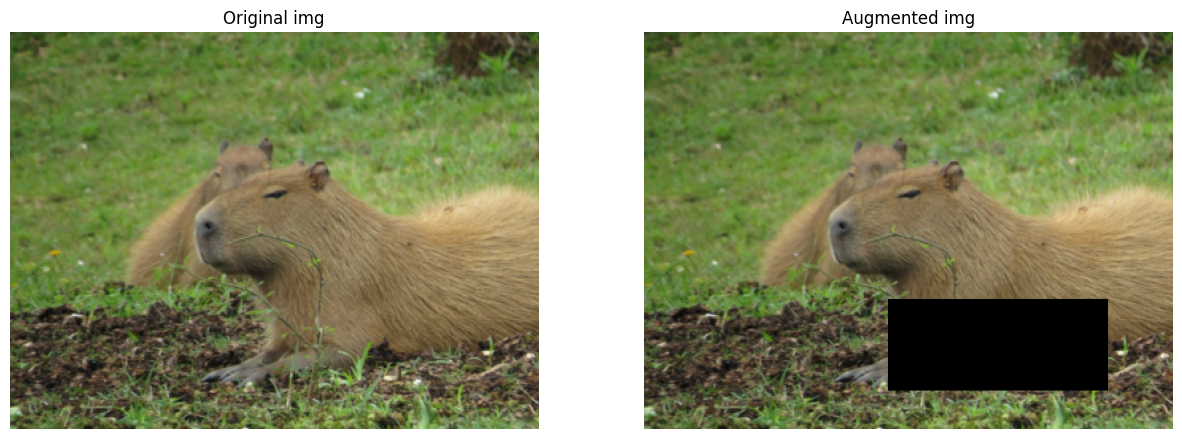

In [7]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(0.02, 0.1)),
        transforms.ToPILImage(),
    ]
)

plot_augmented_img(transform, input_img)

## ColorJitter
`transforms.ColorJitter` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html?highlight=colorjitter#torchvision.transforms.ColorJitter) случайным образом меняет яркость, контрастность, насыщенность и оттенок изображения.

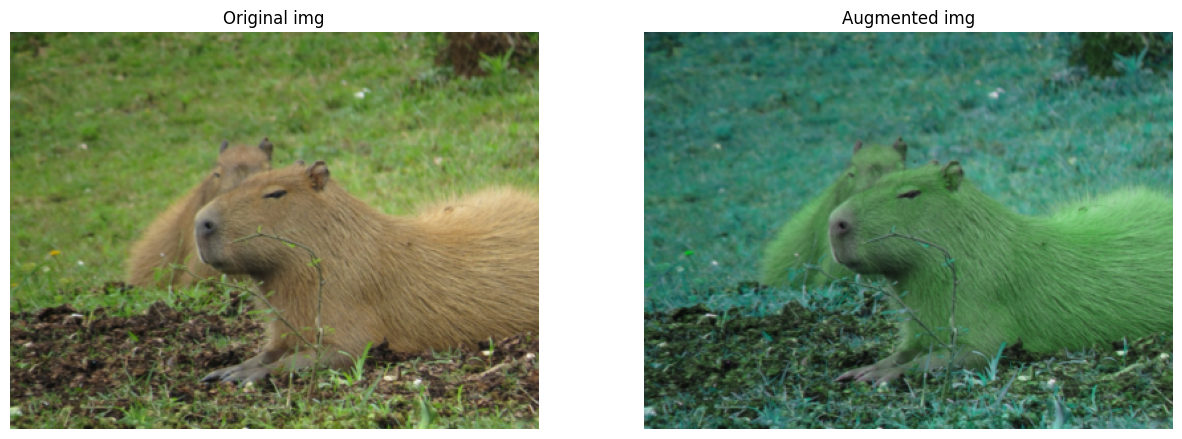

In [8]:
transform = transforms.ColorJitter(brightness=0.5, hue=0.3)

plot_augmented_img(transform, input_img)

## Совмещаем несколько аугментаций вместе

Для этого будем использовать метод `transforms.Compose` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html?highlight=compose#torchvision.transforms.Compose), с которым мы хорошо знакомы. Нам нужно будет создать `list` со всеми аугментациями, которые будут применены последовательно.

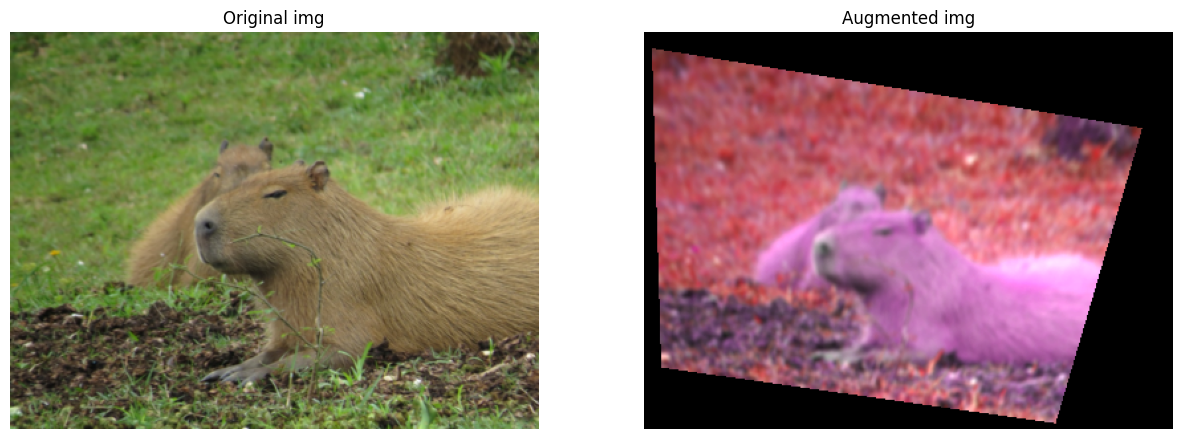

In [9]:
transform = transforms.Compose(
    [
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
    ]
)

plot_augmented_img(transform, input_img)

## Совмещение нескольких аугментаций случайным образом

Как видно, три аугментации, примененные последовательно, достаточно сильно изменили картинку. Разумнее применять не все сразу. Для этого есть соответствующие классы.

### <font size="4">Random Apply</font>

Для того, чтобы применять аугментации случайным образом, можно воспользоваться классом `transforms.RandomApply` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomApply.html?highlight=randomapply#torchvision.transforms.RandomApply), конструктор которого принимает на вход  список аугментаций и вероятность `p`, с которой каждая аугментация будет применена.

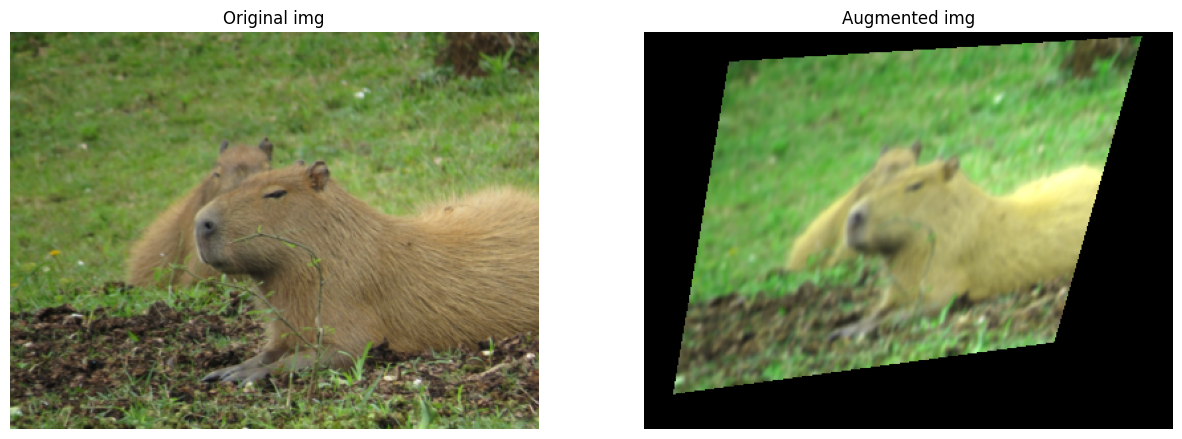

In [10]:
transform = transforms.RandomApply(
    transforms=[
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomPerspective(distortion_scale=0.5),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
    ],
    p=0.9,
)

plot_augmented_img(transform, input_img)

### <font size="4">Random Choice</font>

В других случаях может быть полезен класс `transforms.RandomChoice` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomChoice.html?highlight=randomchoice#torchvision.transforms.RandomChoice), конструктор которого принимает на вход список аугментаций `transforms`, выбирает из него **одну** случайную аугментацию и применяет ее к изображению. Необязательным параметром является список вероятностей `p`, который указывает, с какой вероятностью каждая из аугментаций может быть выбрана из списка (по умолчанию каждая может быть выбрана равновероятно).

In [11]:
transform = transforms.RandomChoice(
    transforms=[
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomPerspective(distortion_scale=0.5, p=1.0),
        transforms.ColorJitter(brightness=0.5, hue=0.3),
    ],
    p=[0.2, 0.4, 0.6],
)

plot_augmented_img(transform, input_img)
plot_augmented_img(transform, input_img)
plot_augmented_img(transform, input_img)

Output hidden; open in https://colab.research.google.com to view.

## Пример создания собственной аугментации

Иногда может оказаться, что среди широкого спектра реализованных аугментаций нет такой, которую вы хотели бы применить к своим данным. В таком случае ее можно описать в виде класса и использовать наравне с реализованными в библиотеке.

Главное, что необходимо описать при создании класса, — метод `__call__`. Он должен принимать изображение (оно может быть представлено в формате `PIL.Image`, `np.array` или `torch.Tensor`), делать с ним интересующие нас видоизменения и возвращать измененное изображение.

Рассмотрим пример добавления на изображение [шума "соль и перец" 📚[wiki]](https://ru.wikipedia.org/wiki/Salt_and_pepper). Наш метод аугментации будет и принимать на вход, и возвращать `PIL.Image`.



In [12]:
import numpy as np
from PIL import Image


class SaltAndPepperNoise:
    """
    Add a "salt and pepper" noise to the PIL image
    __call__ method returns PIL Image with noise
    """

    def __init__(self, p=0.01):
        self.p = p  # noise level

    def __call__(self, pil_image):
        np_image = np.array(pil_image)

        # create random mask for "salt" and "pepper" pixels
        salt_ind = np.random.choice(
            a=[True, False], size=np_image.shape[:2], p=[self.p, 1 - self.p]
        )
        pepper_ind = np.random.choice(
            a=[True, False], size=np_image.shape[:2], p=[self.p, 1 - self.p]
        )

        # add "salt" and "pepper"
        np_image[salt_ind] = 255
        np_image[pepper_ind] = 0

        return Image.fromarray(np_image)

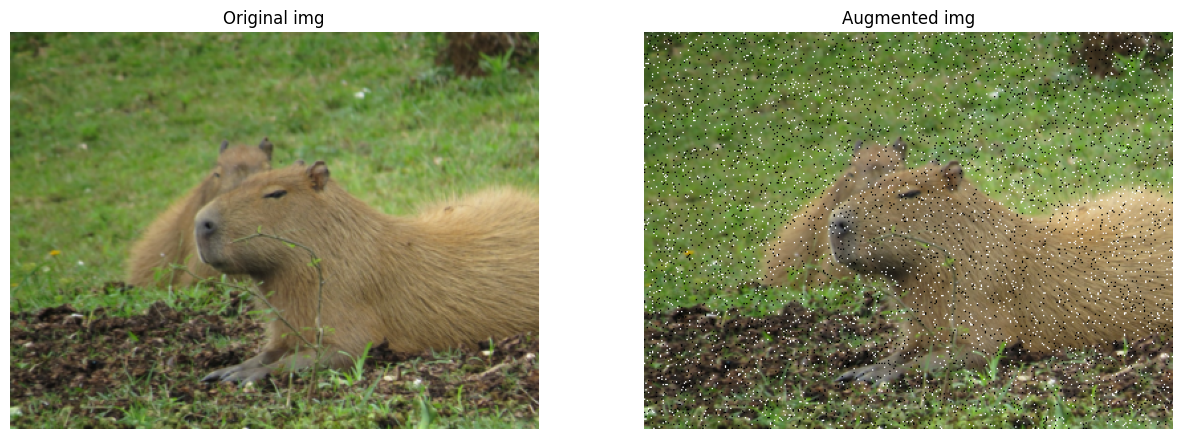

In [13]:
transform = SaltAndPepperNoise(p=0.03)

plot_augmented_img(transform, input_img)

## Аугментация внутри `Dataset`

Возьмем папку с картинками.

In [14]:
# download files
!wget -q "https://ml.gan4x4.ru/msu/datasets/for_transforms.Compose.zip" -O data.zip
!unzip -qn "data.zip"

Напишем класс `AugmentationDataset`:

In [15]:
import glob
from torch.utils.data import Dataset


class AugmentationDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.img_list = glob.glob(root + "*.jpg")
        self.transforms = transforms

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, i):
        img = Image.open(self.img_list[i])
        if self.transforms is not None:
            img = self.transforms(img)
        return img

Создадим `list` с аугментациями, которые мы хотим применить. Многие аугментации в PyTorch работают с Pillow Image, так что картинки не обязательно преобразовывать в тензоры (`transforms.ToTensor()`).

In [16]:
transform = transforms.Compose(
    [
        transforms.Resize((164, 164)),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomPerspective(distortion_scale=0.5),
        # ToTensor()
    ]
)

augmentated_dataset = AugmentationDataset(
    "/content/for_transforms.Compose/", transforms=transform
)

Отобразим аугментированные изображения:

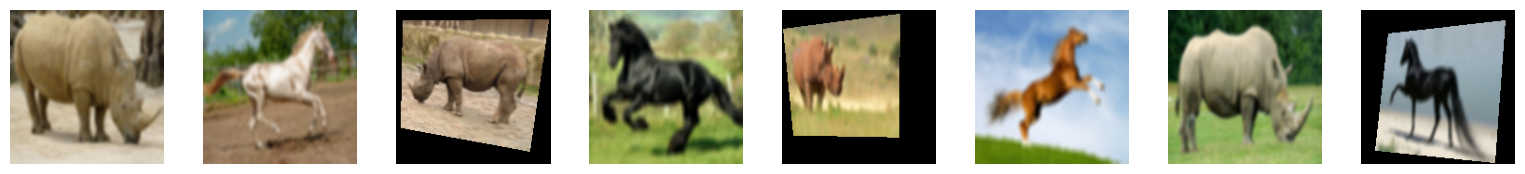

In [17]:
plt.figure(figsize=(22, 2))
for i, img in enumerate(augmentated_dataset):
    plt.subplot(1, len(augmentated_dataset) + 1, 1 + i)
    plt.axis("off")
    plt.imshow(np.array(img))
plt.show()

## Аугментация в реальных задачах

Кроме методов, реализованных в PyTorch, существуют и специализированные библиотеки для аугментации изображений, в которых реализованы дополнительные возможности (например, наложение теней, бликов или пятен воды на изображение).

Например:
- [[doc] 🛠️ Albumentations](https://albumentations.ai)
- [[doc] 🛠️ kornia](https://github.com/kornia/kornia)


**Важно: при выборе методов аугментации имеет смысл использовать только те, которые будут в реальной жизни.**

Например, нет смысла:
- делать перевод изображения в черно-белое, если предполагается, что весь входящий поток будет цветным,
- отражать человека вверх ногами, если мы не предполагаем его таким распознавать.